In [1]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [299, 299]

train_path = 'data/train'
valid_path = 'data/test'

In [3]:
myxception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
# don't train existing weights
for layer in myxception.layers:
    layer.trainable = False

In [5]:
  # useful for getting number of output classes
folders = glob('data/train/*')

In [6]:
# our layers - you can add more if you want
x = Flatten()(myxception.output)

In [7]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=myxception.input, outputs=prediction)

In [8]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [9]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255
                                 )

In [11]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 20000 images belonging to 2 classes.


In [12]:
test_set = test_datagen.flow_from_directory('data/test',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5000 images belonging to 2 classes.


In [13]:
training_set.class_indices

{'cats': 0, 'dogs': 1}

In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=2,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/2
625/625 [==============================] - 667s 1s/step - loss: 0.3272 - accuracy: 0.9872 - val_loss: 0.4412 - val_accuracy: 0.9894
Epoch 2/2
625/625 [==============================] - 331s 530ms/step - loss: 0.3520 - accuracy: 0.9906 - val_loss: 0.7023 - val_accuracy: 0.9902


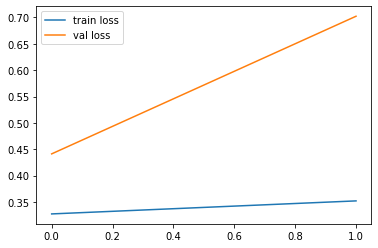

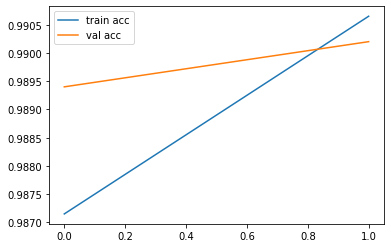

In [16]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [17]:
import tensorflow as tf

from tensorflow.keras.models import load_model

model.save('catdog.h5')

# Below is the explanation for how to use grad-cam

In [549]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [550]:
# load the pre-trained CNN from disk
from tensorflow.keras.models import load_model
model = load_model('catdog.h5', compile = True)

In [551]:
#model.summary()

In [552]:
img_size = (299,299)
preprocess_input = keras.applications.xception.preprocess_input
last_conv_layer_name = "block14_sepconv2_act"

In [553]:
img_path = "cat.jpg"

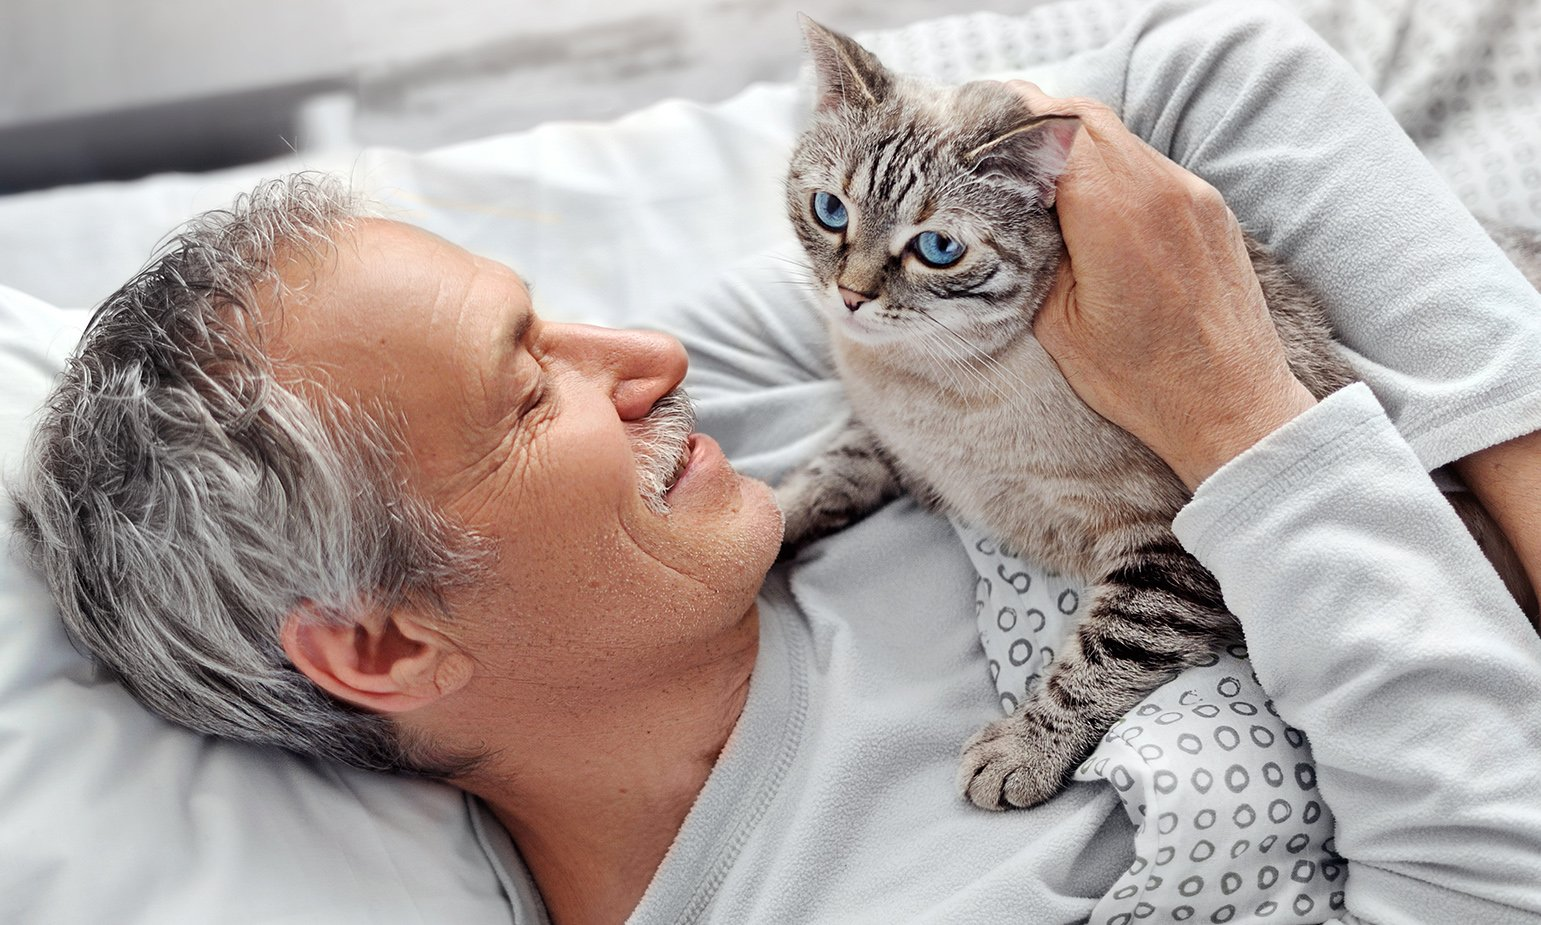

In [554]:
display(Image(img_path))

In [555]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


the probability for both class =  [[1. 0.]]
index of element with max probability 0
the probability of predicted class =  1.0


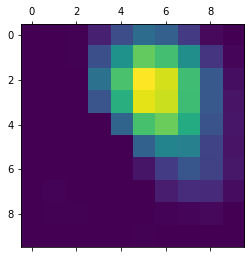

In [556]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))


preds = model.predict(img_array)
print("the probability for both class = ",preds)
#print(preds[0])
# 0 = cat and 1 = dog
i = np.argmax(preds[0])
print("index of element with max probability",i)

print("the probability of predicted class = ",preds[0][i])
model.layers[-1].activation = None
# Generate class activation heatmap
# if u want to find gradient for specific class then choose value of i pr predictive index by yourself
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name,i)

# Display heatmap
plt.matshow(heatmap)
plt.show()

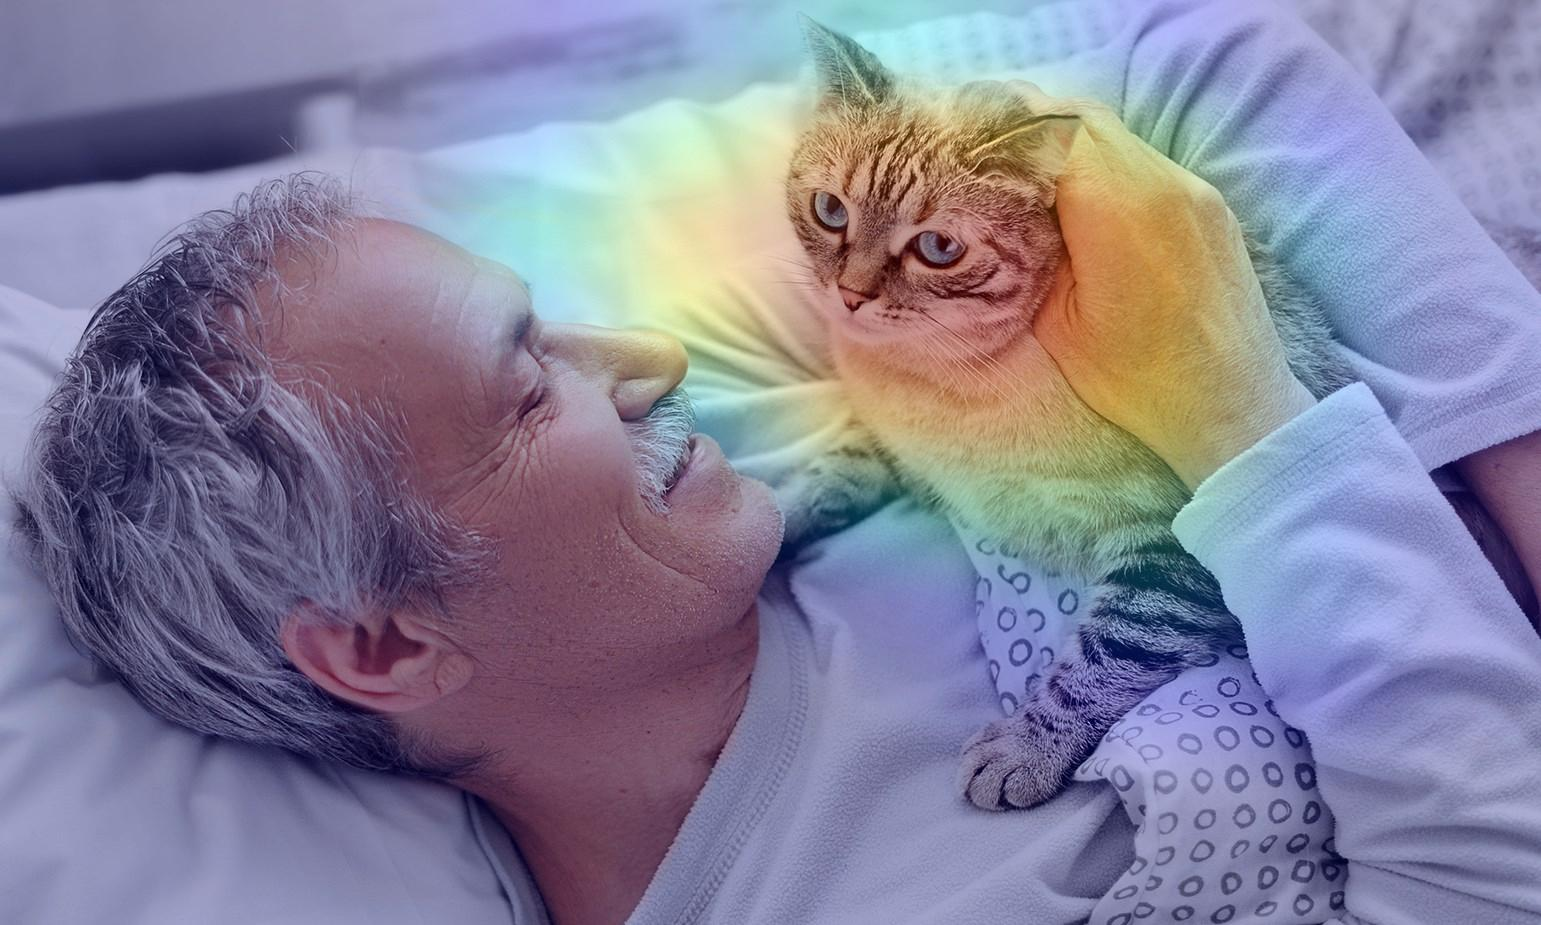

In [557]:
def save_and_display_gradcam(img_path, heatmap, cam_path="gradcam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

save_and_display_gradcam(img_path, heatmap)